In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr, spearmanr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df = pd.read_csv('Data Scientist - Assignment.csv')

**Handling Missing Values**

📌 Tujuan: Mengatasi data yang hilang agar tidak mengganggu analisis dan model.

✅ Tips :

Hapus baris/kolom jika jumlah data yang hilang sedikit dan tidak terlalu berpengaruh.

Imputasi Mean/Median/Mode untuk nilai numerik berdasarkan distribusi data.

Imputasi dengan Forward/Backward Fill untuk data time series.

Gunakan Model Predictive Imputation seperti KNN Imputer atau Iterative Imputer.

Tandai missing values sebagai kategori khusus untuk data kategori.

Cek Data: Melihat informasi dasar seperti jumlah baris, kolom, tipe data, dan data yang hilang.

In [4]:
# Display basic info and check for missing values
print(df.info())
print(df.isnull().sum())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59477 entries, 0 to 59476
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   UniqueID                                 59477 non-null  int64  
 1   Loan To Value                            59477 non-null  float64
 2   Branch ID                                59477 non-null  int64  
 3   Age                                      59477 non-null  int64  
 4   Employment Type                          53626 non-null  object 
 5   DisbursalDate                            59477 non-null  object 
 6   State_ID                                 0 non-null      float64
 7   State                                    59477 non-null  object 
 8   Employee_code_ID                         59477 non-null  int64  
 9   Mobile Avl Flag                          59477 non-null  int64  
 10  VoterID Flag                             59477

Visualisasi Missing Values: Mengecek bagian data yang kosong dengan heatmap agar mudah dipahami.

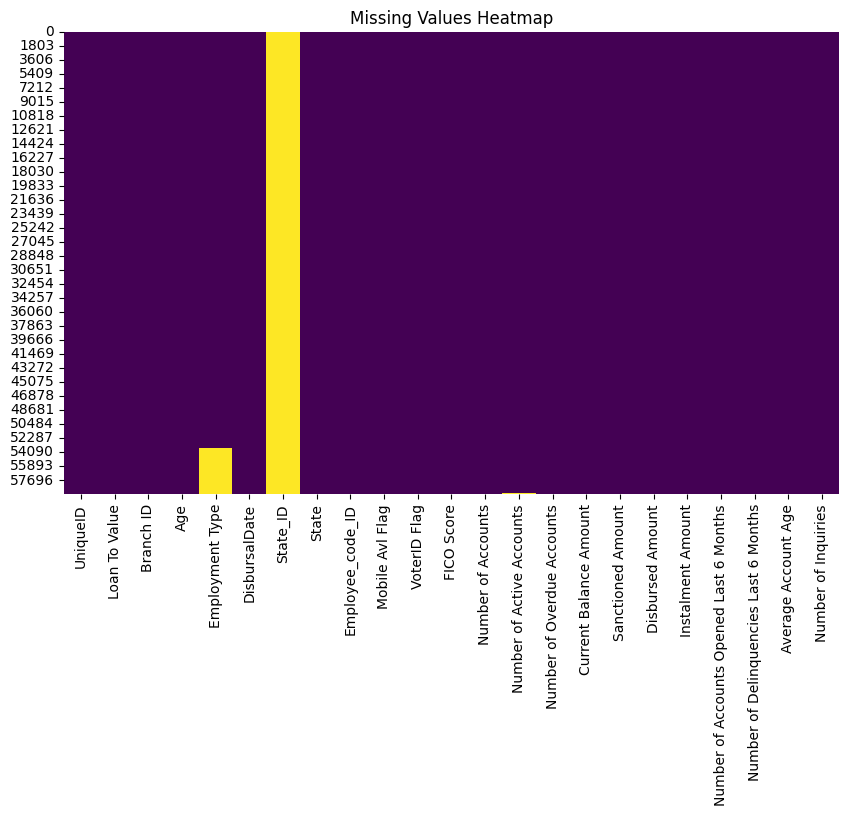

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

Distribusi Data: Menampilkan grafik distribusi nilai pada kolom-kolom numerik seperti skor kredit (Loan To Value) dan usia peminjam.

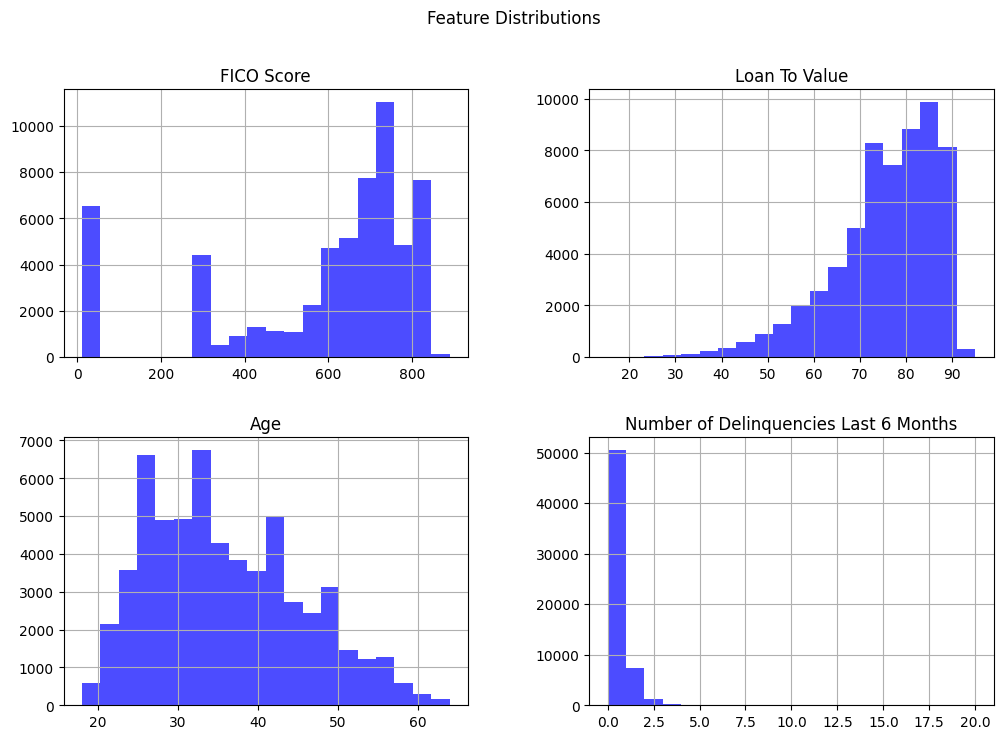

In [ ]:
numerical_columns = ['Loan To Value', 'Loan To Value', 'Age', 'Number of Delinquencies Last 6 Months']
df[numerical_columns].hist(figsize=(12, 8), bins=20, color='blue', alpha=0.7)
plt.suptitle('Feature Distributions')
plt.show()

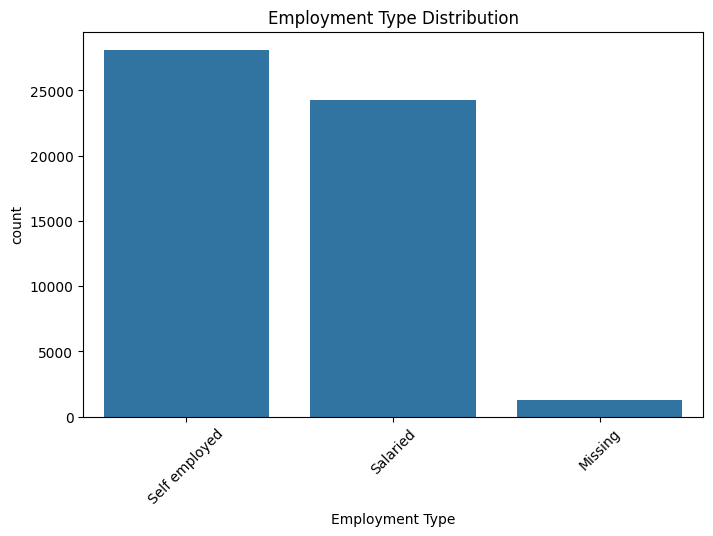

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Employment Type', order=df['Employment Type'].value_counts().index)
plt.title('Employment Type Distribution')
plt.xticks(rotation=45)
plt.show()

Hubungan Antar Variabel: Menggunakan scatterplot untuk melihat pola hubungan antar fitur seperti rasio pinjaman dan usia.

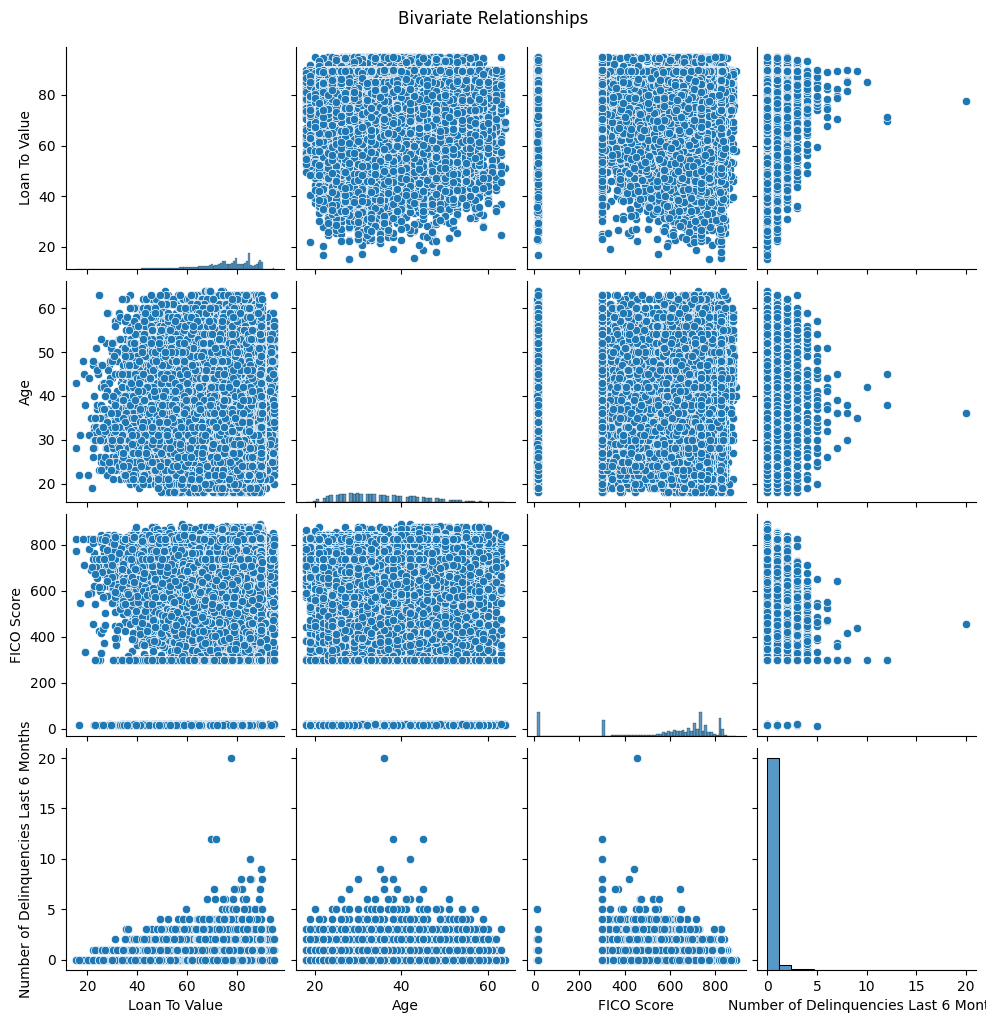

In [ ]:
sns.pairplot(df, vars=['Loan To Value', 'Age', 'Loan To Value', 'Number of Delinquencies Last 6 Months'])
plt.suptitle('Bivariate Relationships', y=1.02)
plt.show()

Membersihkan Data: Menghapus kolom yang tidak relevan, mengisi nilai yang hilang, dan memperbaiki anomali seperti nilai negatif yang tidak masuk akal.

In [9]:
# Dropping unusable columns
df.drop(columns=['State_ID'], inplace=True)

# Handling missing values
df['Employment Type'] = df['Employment Type'].fillna('Unknown')
df['Number of Active Accounts'] = df['Number of Active Accounts'].fillna(df['Number of Active Accounts'].median())

# Fixing negative Current Balance Amount
df['Current Balance Amount'] = df['Current Balance Amount'].apply(lambda x: max(x, 0))

In [10]:
# Checking again to be sure all missing values are handled
print(df.isnull().sum())

UniqueID                                   0
Loan To Value                              0
Branch ID                                  0
Age                                        0
Employment Type                            0
DisbursalDate                              0
State                                      0
Employee_code_ID                           0
Mobile Avl Flag                            0
VoterID Flag                               0
FICO Score                                 0
Number of Accounts                         0
Number of Active Accounts                  0
Number of Overdue Accounts                 0
Current Balance Amount                     0
Sanctioned Amount                          0
Disbursed Amount                           0
Instalment Amount                          0
Number of Accounts Opened Last 6 Months    0
Number of Delinquencies Last 6 Months      0
Average Account Age                        0
Number of Inquiries                        0
dtype: int

Delinquency Ratio: Mengukur rasio tunggakan pembayaran terhadap total akun kredit.

In [11]:
df['Delinquency Ratio'] = df['Number of Overdue Accounts'] / (df['Number of Accounts'] + 1e-5)

Loan Utilization: Menghitung seberapa banyak pinjaman yang sudah digunakan dari total yang disetujui.

In [12]:
df['Loan Utilization'] = df['Disbursed Amount'] / (df['Sanctioned Amount'] + 1e-5)

Kategori Loan To Value: Mengelompokkan skor kredit ke dalam kategori seperti "Poor", "Fair", "Good", dan "Excellent".

In [13]:
def fico_category(score):
    if score < 300: return 'Excluded'
    elif score < 580: return 'Poor'
    elif score < 670: return 'Fair'
    elif score < 740: return 'Good'
    else: return 'Excellent'

df['FICO Category'] = df['Loan To Value'].apply(fico_category)

Account Age Group: Mengelompokkan usia akun kredit menjadi “Low”, “Medium”, atau “High”.

In [14]:
bins = [0, 12, 36, 100]
labels = ['Low', 'Medium', 'High']
df['Account Age Group'] = pd.cut(df['Average Account Age'], bins=bins, labels=labels)

In [15]:
df

,UniqueID,Loan To Value,Branch ID,Age,Employment Type,DisbursalDate,State,Employee_code_ID,Mobile Avl Flag,VoterID Flag,...,Disbursed Amount,Instalment Amount,Number of Accounts Opened Last 6 Months,Number of Delinquencies Last 6 Months,Average Account Age,Number of Inquiries,Delinquency Ratio,Loan Utilization,FICO Category,Account Age Group
0,537409,73.23,67,33,Self employed,26/09/2018,Nevada,1998,1,0,...,50200,1991,0,1,13,0,0.99999,1.0,Fair,Medium
1,624493,88.48,67,25,Self employed,26/10/2018,Nevada,1998,1,0,...,0,31,0,0,8,1,0.00000,0.0,Poor,Low
2,518279,89.66,67,28,Self employed,19/09/2018,Nevada,1998,1,0,...,0,1347,0,0,21,0,0.00000,0.0,Excellent,Medium
3,510278,71.89,67,29,Salaried,16/09/2018,Nevada,1998,1,0,...,74500,0,0,0,2,0,0.00000,1.0,Excluded,Low
4,490213,89.56,67,27,Self employed,05/09/2018,Nevada,1998,1,0,...,365384,0,0,0,56,1,0.00000,1.0,Good,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59472,650784,71.82,254,26,Unknown,31/10/2018,Colorado,1998,1,1,...,53512,0,1,0,0,0,0.00000,1.0,Excluded,NaN
59473,473780,65.99,254,33,Unknown,29/08/2018,Colorado,1998,1,1,...,225000,0,0,0,1,0,0.00000,1.0,Fair,Low
59474,617679,67.21,254,31,Unknown,25/10/2018,Colorado,1998,1,1,...,30000,1600,0,0,9,0,0.00000,1.0,Good,Low
59475,483987,48.59,254,52,Unknown,31/08/2018,Colorado,1998,1,0,...,35895,0,1,0,0,0,0.00000,1.0,Excluded,NaN


In [16]:
# Checking for missing values
df.isnull().sum()

UniqueID                                      0
Loan To Value                                 0
Branch ID                                     0
Age                                           0
Employment Type                               0
DisbursalDate                                 0
State                                         0
Employee_code_ID                              0
Mobile Avl Flag                               0
VoterID Flag                                  0
FICO Score                                    0
Number of Accounts                            0
Number of Active Accounts                     0
Number of Overdue Accounts                    0
Current Balance Amount                        0
Sanctioned Amount                             0
Disbursed Amount                              0
Instalment Amount                             0
Number of Accounts Opened Last 6 Months       0
Number of Delinquencies Last 6 Months         0
Average Account Age                     

In [17]:
# Fill missing Account Age Group
bins = [0, 12, 36, 100]
labels = ['Low', 'Medium', 'High']
df['Account Age Group'] = pd.cut(df['Average Account Age'], bins=bins, labels=labels, include_lowest=True)

In [18]:
# Checking for missing values again to be sure everything is resolved
df.isna().sum()

UniqueID                                     0
Loan To Value                                0
Branch ID                                    0
Age                                          0
Employment Type                              0
DisbursalDate                                0
State                                        0
Employee_code_ID                             0
Mobile Avl Flag                              0
VoterID Flag                                 0
FICO Score                                   0
Number of Accounts                           0
Number of Active Accounts                    0
Number of Overdue Accounts                   0
Current Balance Amount                       0
Sanctioned Amount                            0
Disbursed Amount                             0
Instalment Amount                            0
Number of Accounts Opened Last 6 Months      0
Number of Delinquencies Last 6 Months        0
Average Account Age                          0
Number of Inq

In [19]:
# Defining bins and labels for Account Age Group
bins = [0, 12, 36, float('inf')]  
labels = ['Low', 'Medium', 'High']

# Fill missing Account Age Group based on Average Account Age
df['Account Age Group'] = pd.cut(df['Average Account Age'], bins=bins, labels=labels, include_lowest=True)

# Verifying missing values are resolved
print(df['Account Age Group'].isnull().sum())

0


In [20]:
# Validate the imputation
print(df[['Average Account Age', 'Account Age Group']].sample(10))

       Average Account Age Account Age Group
45988                   45              High
30594                   13            Medium
4857                    43              High
53216                   27            Medium
33793                    3               Low
35073                   28            Medium
21726                    6               Low
11443                    2               Low
29892                   29            Medium
17278                   17            Medium


In [21]:
df.isna().sum()

UniqueID                                   0
Loan To Value                              0
Branch ID                                  0
Age                                        0
Employment Type                            0
DisbursalDate                              0
State                                      0
Employee_code_ID                           0
Mobile Avl Flag                            0
VoterID Flag                               0
FICO Score                                 0
Number of Accounts                         0
Number of Active Accounts                  0
Number of Overdue Accounts                 0
Current Balance Amount                     0
Sanctioned Amount                          0
Disbursed Amount                           0
Instalment Amount                          0
Number of Accounts Opened Last 6 Months    0
Number of Delinquencies Last 6 Months      0
Average Account Age                        0
Number of Inquiries                        0
Delinquenc

**Scaling dan Encoding**

📌 Tujuan: Menyamakan skala fitur numerik dan mengonversi fitur kategorikal agar bisa digunakan dalam model.

✅ Tips :

Gunakan StandardScaler untuk distribusi normal.

Gunakan MinMaxScaler jika data tidak berdistribusi normal.

Gunakan One-Hot Encoding untuk data kategorikal dengan sedikit kategori unik.

Gunakan Label Encoding jika ada urutan dalam kategori.

Gunakan Target Encoding untuk kategori dengan jumlah nilai unik yang besar.

Normalisasi Data: Mengubah skala data numerik agar memiliki nilai yang seragam untuk memudahkan analisis dan model pembelajaran mesin.

In [22]:
numerical_features = [
    'Loan To Value', 'Age', 'Current Balance Amount', 
    'Loan Utilization', 'Delinquency Ratio', 
    'Number of Accounts Opened Last 6 Months', 'Number of Inquiries'
]

# Initializing the scaler
scaler = StandardScaler()

# Scaling the numerical features
df_scaled_array = scaler.fit_transform(df[numerical_features])

# Converting the scaled array back to a DataFrame
df_scaled = pd.DataFrame(df_scaled_array, columns=numerical_features)

df[numerical_features] = df_scaled

print(df.head())

   UniqueID  Loan To Value  Branch ID       Age Employment Type DisbursalDate  \
0    537409      -0.207890         67 -0.305198   Self employed    26/09/2018   
1    624493       1.133664         67 -1.145975   Self employed    26/10/2018   
2    518279       1.237469         67 -0.830684   Self employed    19/09/2018   
3    510278      -0.325771         67 -0.725587        Salaried    16/09/2018   
4    490213       1.228672         67 -0.935781   Self employed    05/09/2018   

    State  Employee_code_ID  Mobile Avl Flag  VoterID Flag  ...  \
0  Nevada              1998                1             0  ...   
1  Nevada              1998                1             0  ...   
2  Nevada              1998                1             0  ...   
3  Nevada              1998                1             0  ...   
4  Nevada              1998                1             0  ...   

   Disbursed Amount  Instalment Amount  \
0             50200               1991   
1                 0       

Mencari Hubungan Antar Variabel: Menggunakan heatmap untuk melihat mana variabel yang paling berpengaruh terhadap risiko kredit.

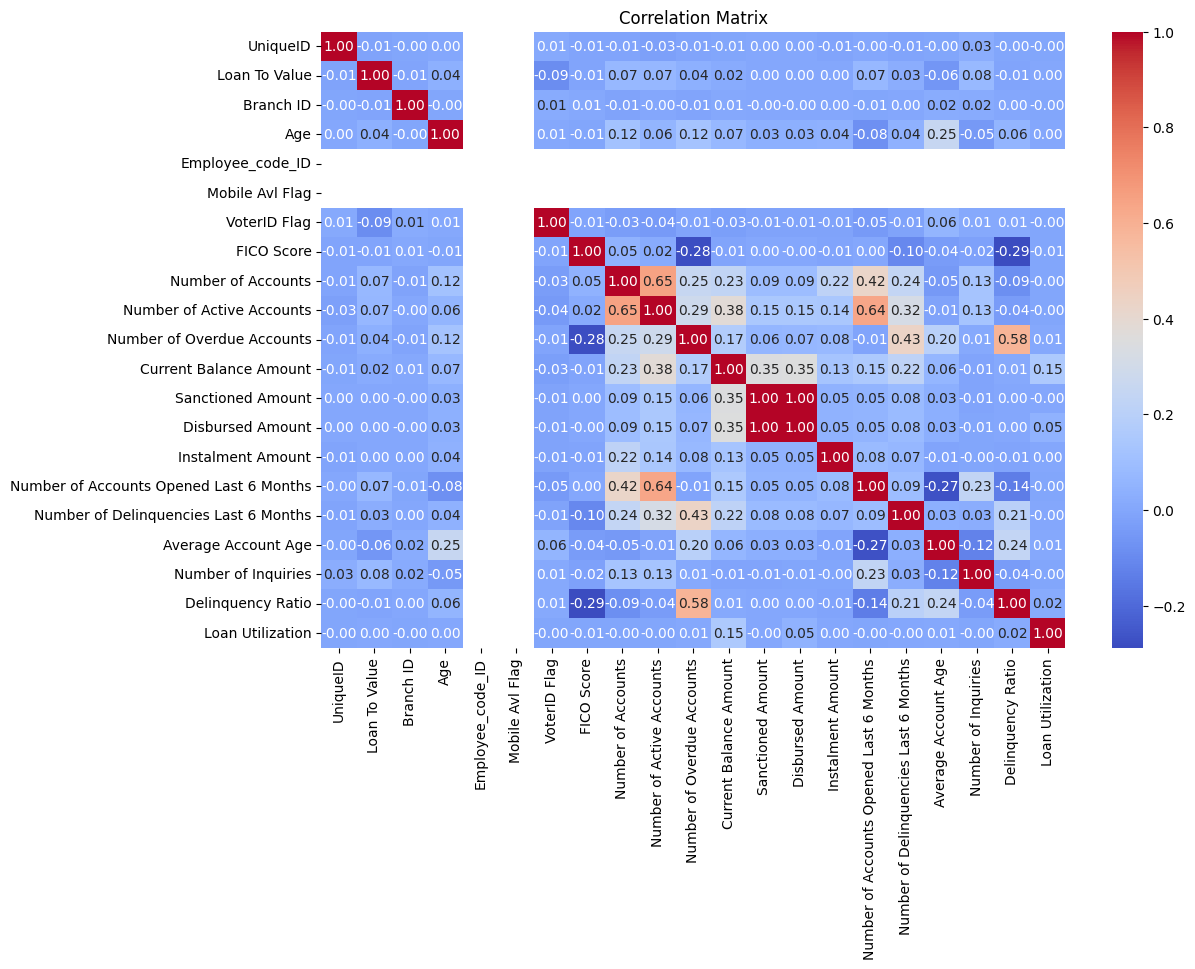

In [23]:
numerical_df = df.select_dtypes(include=['number'])
numerical_df = numerical_df.fillna(0)  
corr = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [24]:
selected_cols = ['Loan To Value', 'Loan To Value', 'Age', 'Number of Delinquencies Last 6 Months']
corr = df[selected_cols].corr()

**Feature Engineering**

📌 Tujuan: Membuat fitur baru yang lebih relevan untuk meningkatkan performa model.

✅ Tips :

Transformasi log/square root untuk mengurangi skewness.

Buat fitur baru dengan kombinasi fitur yang ada.

Gunakan domain knowledge untuk fitur yang lebih bermakna.

Gunakan teknik PCA jika fitur terlalu banyak.

K-Means Clustering: Mengelompokkan nasabah ke dalam beberapa kategori risiko (misalnya, risiko rendah, sedang, dan tinggi) berdasarkan pola data mereka.

In [26]:
# Performing KMeans clustering with 3 clusters 
kmeans = KMeans(n_clusters=3, random_state=42)
df['Risk Category'] = kmeans.fit_predict(df_scaled)

# Checking the first few rows to see the assigned clusters (Risk Category)
print(df[['UniqueID', 'Risk Category']].head())

# If you want to check the cluster centroids, you can do so as follows:
print("Cluster Centroids:")
print(kmeans.cluster_centers_)

   UniqueID  Risk Category
0    537409              0
1    624493              1
2    518279              1
3    510278              1
4    490213              1
Cluster Centroids:
[[-4.34512013e-02  1.34267471e-01 -4.89283302e-02 -1.85155049e-03
   2.89303688e+00 -4.74444595e-01 -1.43155876e-01]
 [ 4.12596101e-03 -1.27706349e-02  3.96363876e-03 -4.26372136e-03
  -2.75027753e-01  4.51025517e-02  1.36122751e-02]
 [ 1.97654774e-01  5.35578918e-01  3.72869648e+01  2.41137466e+02
   4.00098177e+00 -6.16996166e-01 -3.66477774e-01]]


PCA (Principal Component Analysis): Mengurangi dimensi data agar lebih mudah divisualisasikan dalam grafik 2D.

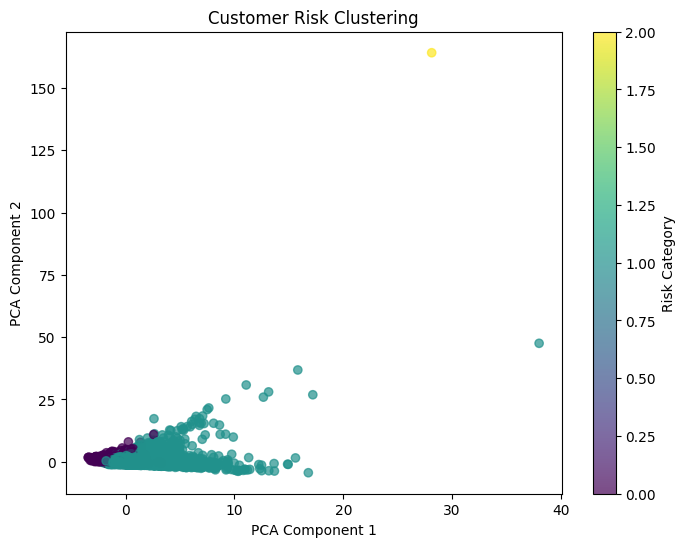

In [27]:
# Reducing the dimensions to 2D using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Risk Category'], cmap='viridis', alpha=0.7)
plt.title('Customer Risk Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Risk Category')
plt.show()

**Clustering & Silhouette Score**

📌 Tujuan: Mengelompokkan data secara otomatis menggunakan algoritma clustering.

✅ Tips:

Gunakan K-Means jika data memiliki pola berbentuk bulat.

Gunakan DBSCAN jika ada data dengan bentuk tidak beraturan.

Evaluasi jumlah cluster dengan Elbow Method dan Silhouette Score.

Silhouette Score: Mengevaluasi kualitas pengelompokan data.

In [28]:
# Calculating the Silhouette Score
sil_score = silhouette_score(df_scaled, df['Risk Category'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.364529429833819


In [29]:
# Selecting only numeric columns for aggregation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Group by 'Risk Category' and calculate the mean for numeric columns
cluster_means = df.groupby('Risk Category')[numeric_columns].mean()
print(cluster_means)

                    UniqueID  Loan To Value  Branch ID       Age  \
Risk Category                                                      
0              532665.086965      -0.043475  62.129770  0.134121   
1              533539.445658       0.004129  61.997275 -0.012759   
2              492173.000000       0.197655   5.000000  0.535579   

               Employee_code_ID  Mobile Avl Flag  VoterID Flag  FICO Score  \
Risk Category                                                                
0                        1998.0              1.0      0.156304  394.626186   
1                        1998.0              1.0      0.136339  603.786018   
2                        1998.0              1.0      0.000000  300.000000   

               Number of Accounts  Number of Active Accounts  ...  \
Risk Category                                                 ...   
0                        2.292466                   1.416812  ...   
1                        4.965349                   2.094379 

In [30]:
# Checking the mode (most frequent value) for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_modes = df.groupby('Risk Category')[categorical_columns].agg(lambda x: x.mode()[0])
print(categorical_modes)

              Employment Type DisbursalDate      State FICO Category
Risk Category                                                       
0               Self employed    31/10/2018  Louisiana          Poor
1               Self employed    31/10/2018  Louisiana          Good
2                    Salaried    06/09/2018       Ohio          Poor


In [31]:
# Filtering out the numeric columns for the aggregation
numeric_cols = df.select_dtypes(include='number').columns

# Perform the aggregation
group_summary = df.groupby('Risk Category')[numeric_cols].mean()

# Handle non-numeric columns separately (e.g., Employment Type)
employment_type_summary = df.groupby('Risk Category')['Employment Type'].apply(lambda x: x.mode()[0])

# Combining both summaries into one DataFrame
final_summary = pd.concat([group_summary, employment_type_summary], axis=1)

print(final_summary)

                    UniqueID  Loan To Value  Branch ID       Age  \
Risk Category                                                      
0              532665.086965      -0.043475  62.129770  0.134121   
1              533539.445658       0.004129  61.997275 -0.012759   
2              492173.000000       0.197655   5.000000  0.535579   

               Employee_code_ID  Mobile Avl Flag  VoterID Flag  FICO Score  \
Risk Category                                                                
0                        1998.0              1.0      0.156304  394.626186   
1                        1998.0              1.0      0.136339  603.786018   
2                        1998.0              1.0      0.000000  300.000000   

               Number of Accounts  Number of Active Accounts  ...  \
Risk Category                                                 ...   
0                        2.292466                   1.416812  ...   
1                        4.965349                   2.094379 

In [32]:
final_summary

,UniqueID,Loan To Value,Branch ID,Age,Employee_code_ID,Mobile Avl Flag,VoterID Flag,FICO Score,Number of Accounts,Number of Active Accounts,...,Disbursed Amount,Instalment Amount,Number of Accounts Opened Last 6 Months,Number of Delinquencies Last 6 Months,Average Account Age,Number of Inquiries,Delinquency Ratio,Loan Utilization,Risk Category,Employment Type
Risk Category,,,,,,,,,,,,,,,,,,,,,
0,532665.086965,-0.043475,62.129770,0.134121,1998.0,1.0,0.156304,394.626186,2.292466,1.416812,...,3.466112e+05,9228.88069,-0.474472,0.414875,26.775131,-0.143199,2.892740,-0.001852,0.0,Self employed
1,533539.445658,0.004129,61.997275,-0.012759,1998.0,1.0,0.136339,603.786018,4.965349,2.094379,...,4.372253e+05,21470.76466,0.045115,0.167916,14.768122,0.013619,-0.275058,-0.004264,1.0,Self employed
2,492173.000000,0.197655,5.000000,0.535579,1998.0,1.0,0.000000,300.000000,1.000000,1.000000,...,5.000000e+07,0.00000,-0.616996,0.000000,45.000000,-0.366478,4.000982,241.137466,2.0,Salaried


In [33]:
numeric_columns = df.select_dtypes(include='number').columns
summary_stats = df.groupby('Risk Category')[numeric_columns].mean()

employment_mode = df.groupby('Risk Category')['Employment Type'].apply(lambda x: x.mode()[0])

final_summary = pd.concat([summary_stats, employment_mode], axis=1)

df['Employment Type'] = df['Employment Type'].astype('category')
df['Employment Type Code'] = df['Employment Type'].cat.codes  # Encoding

correlation_matrix = df[numeric_columns].corr()

print("Summary Statistics:")
print(final_summary)
print("\nCorrelation Matrix:")
print(correlation_matrix)

Summary Statistics:
                    UniqueID  Loan To Value  Branch ID       Age  \
Risk Category                                                      
0              532665.086965      -0.043475  62.129770  0.134121   
1              533539.445658       0.004129  61.997275 -0.012759   
2              492173.000000       0.197655   5.000000  0.535579   

               Employee_code_ID  Mobile Avl Flag  VoterID Flag  FICO Score  \
Risk Category                                                                
0                        1998.0              1.0      0.156304  394.626186   
1                        1998.0              1.0      0.136339  603.786018   
2                        1998.0              1.0      0.000000  300.000000   

               Number of Accounts  Number of Active Accounts  ...  \
Risk Category                                                 ...   
0                        2.292466                   1.416812  ...   
1                        4.965349        

In [34]:
# Identifying high correlation variables (with Delinquency Ratio or Risk Category)
high_corr_columns = correlation_matrix[correlation_matrix['Delinquency Ratio'].abs() > 0.5].index
print(f"Highly correlated features with Delinquency Ratio: {high_corr_columns}")

Highly correlated features with Delinquency Ratio: Index(['Number of Overdue Accounts', 'Delinquency Ratio', 'Risk Category'], dtype='object')


In [35]:
# Analyzing correlation between Loan To Value and Delinquency Ratio
fico_corr, _ = pearsonr(df['Loan To Value'], df['Delinquency Ratio'])
print(f"Correlation between Loan To Value and Delinquency Ratio: {fico_corr}")

Correlation between FICO Score and Delinquency Ratio: -0.2878790550659017


In [36]:
# Investigating Number of Accounts vs Delinquency Ratio
accounts_corr, _ = spearmanr(df['Number of Accounts'], df['Delinquency Ratio'])
print(f"Spearman's correlation between Number of Accounts and Delinquency Ratio: {accounts_corr}")

Spearman's correlation between Number of Accounts and Delinquency Ratio: 0.1556412828890499


In [37]:
df['Risk Category'] = df['Risk Category'].astype('category')

Mempersiapkan Data: Memisahkan data menjadi data pelatihan dan data pengujian.

In [38]:
X = df.drop(columns=['Risk Category', 'UniqueID']) 
y = df['Risk Category']  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Menangani Data Kosong: Mengisi data yang kosong dengan rata-rata atau nilai paling umum.

In [39]:
# Filling numerical columns with mean
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numerical_cols] = X_train[numerical_cols].fillna(X_train[numerical_cols].mean())

# Filling categorical columns with mode (most frequent value)
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns
for col in categorical_cols:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])

In [64]:
print(X.info())  # Cek tipe data di setiap kolom
print(X.isna().sum())  # Cek jumlah nilai NaN per kolom
print(X.applymap(lambda x: isinstance(x, str)).sum())  # Cek jumlah nilai string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52955 entries, 0 to 52954
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   UniqueID                                 52955 non-null  int64   
 1   Loan To Value                            52955 non-null  float64 
 2   Branch ID                                52955 non-null  int64   
 3   Age                                      52955 non-null  float64 
 4   Employment Type                          52955 non-null  category
 5   DisbursalDate                            52955 non-null  object  
 6   State                                    52955 non-null  object  
 7   Employee_code_ID                         52955 non-null  int64   
 8   Mobile Avl Flag                          52955 non-null  int64   
 9   VoterID Flag                             52955 non-null  int64   
 10  Number of Accounts                

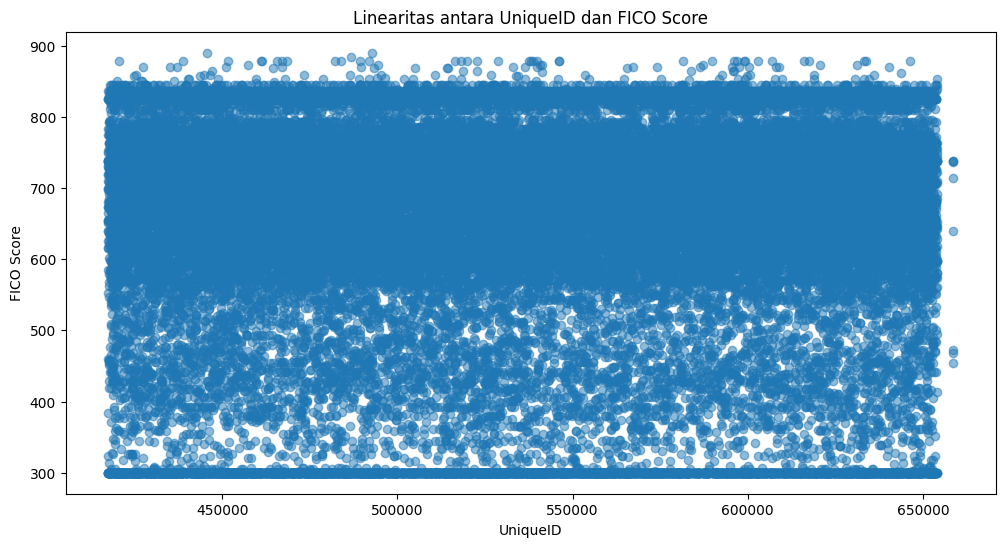

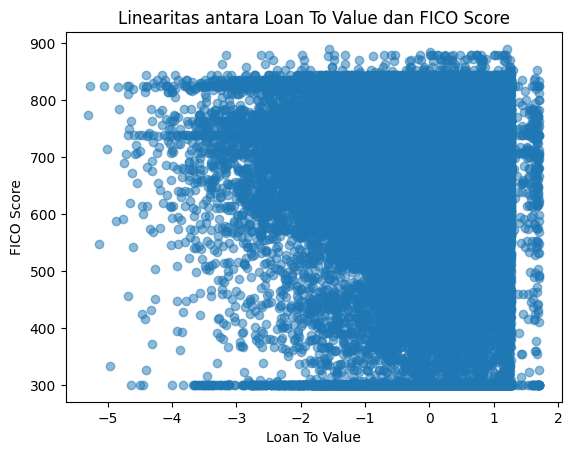

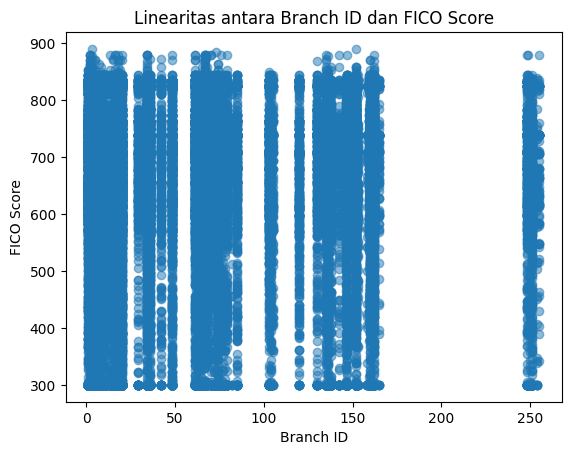

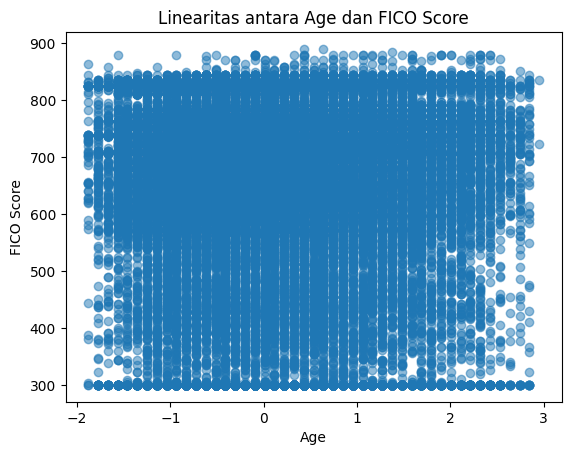

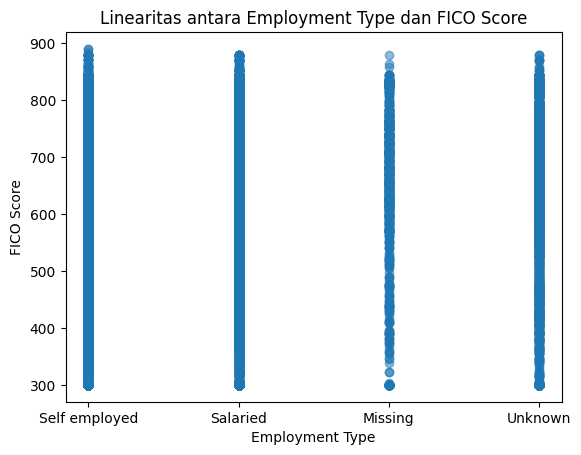

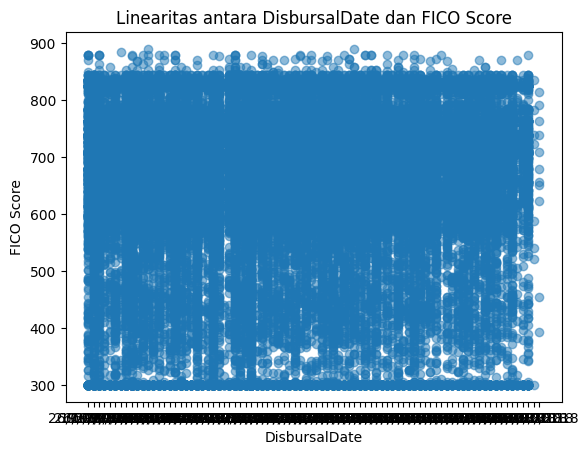

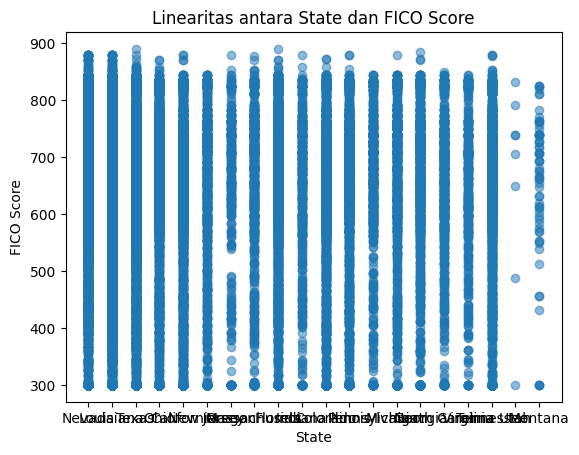

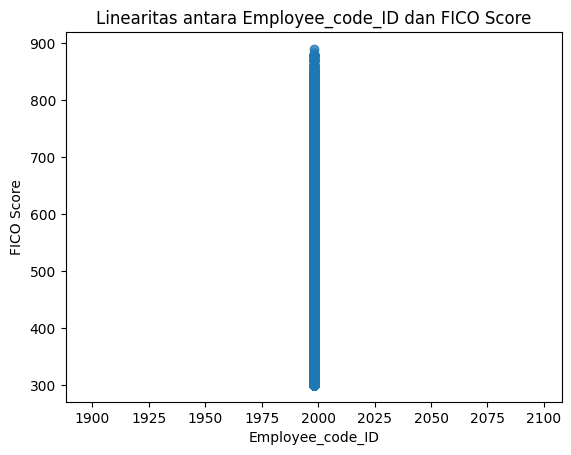

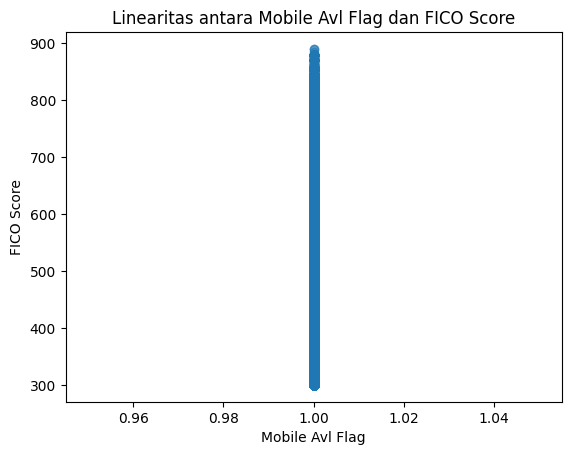

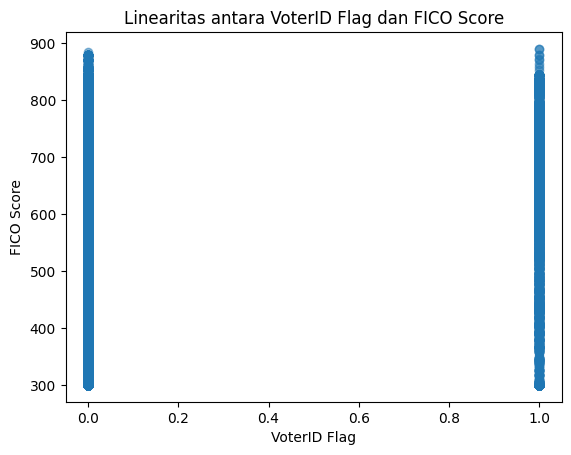

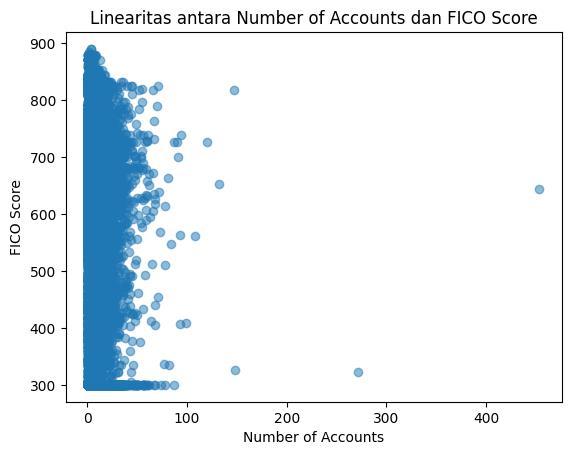

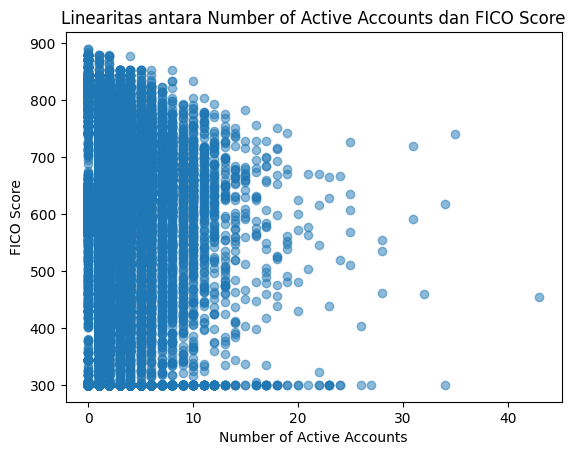

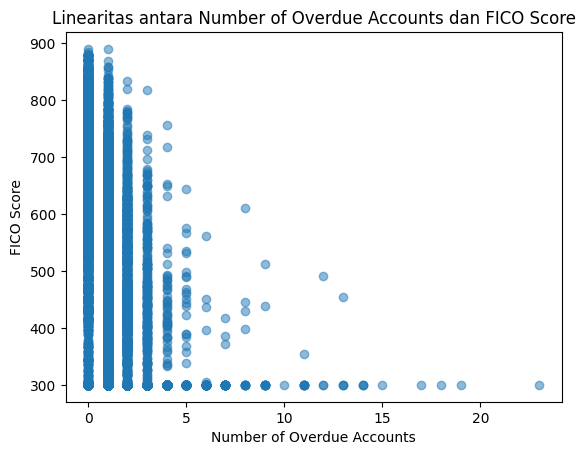

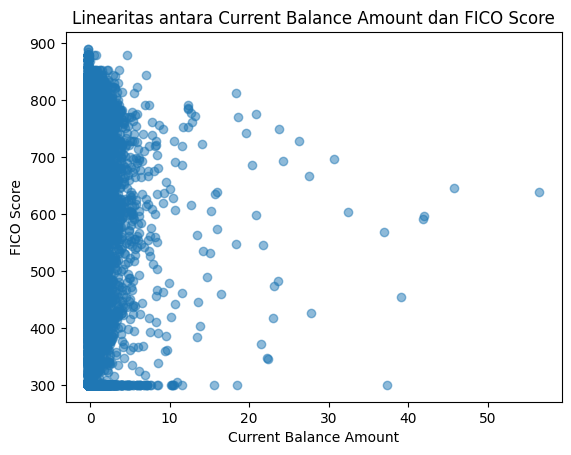

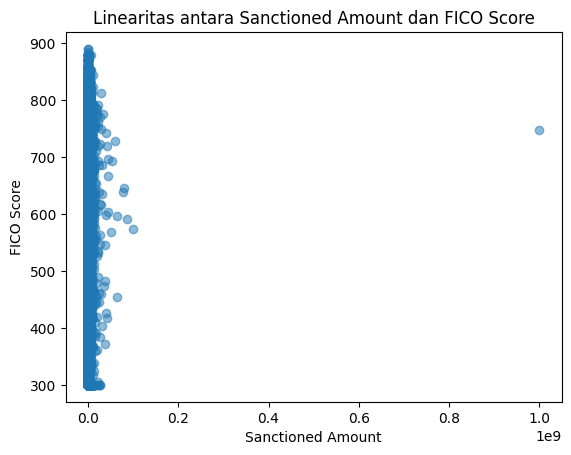

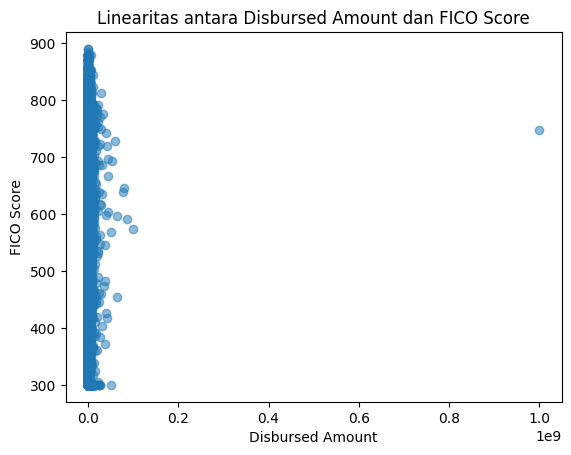

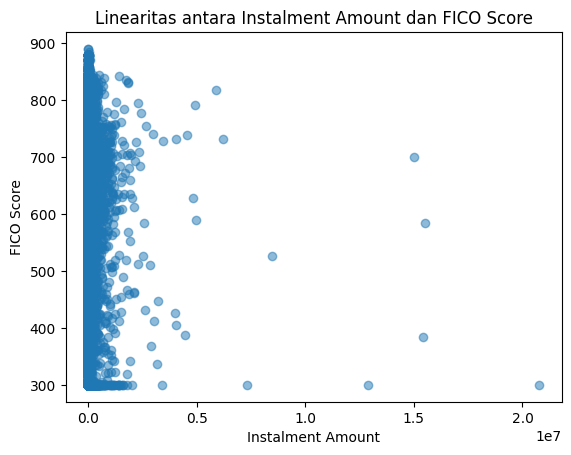

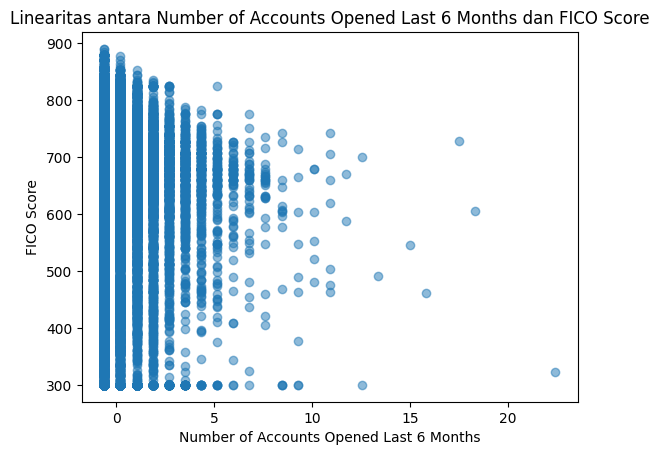

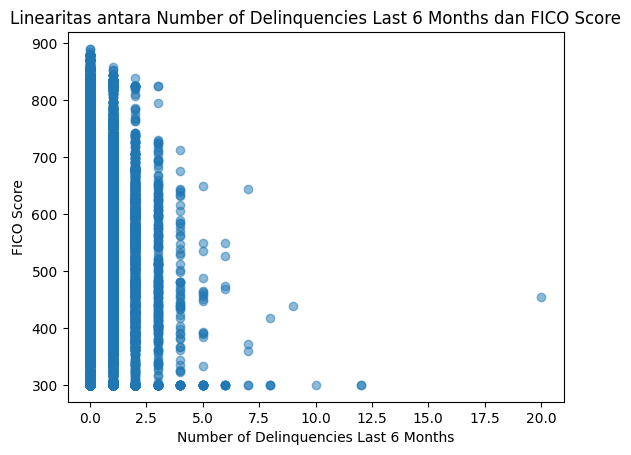

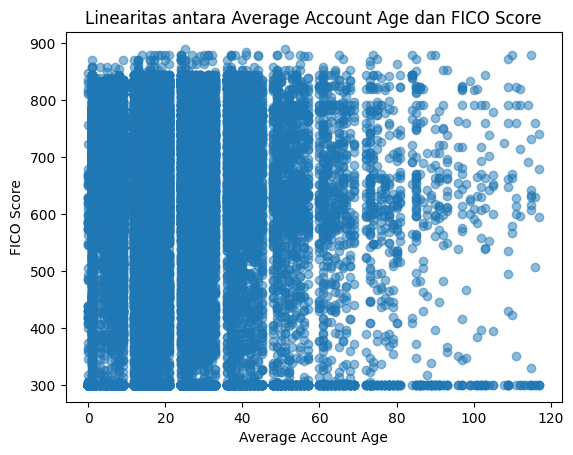

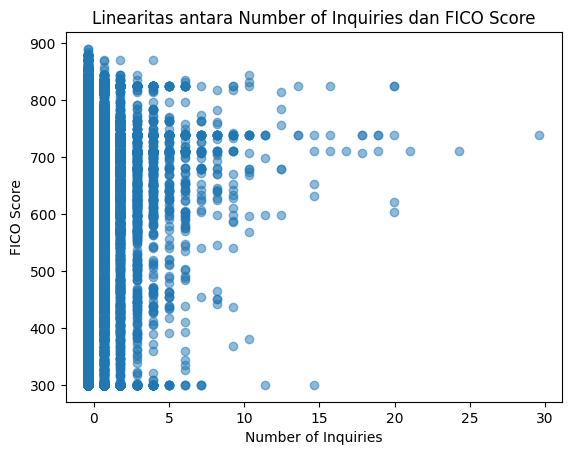

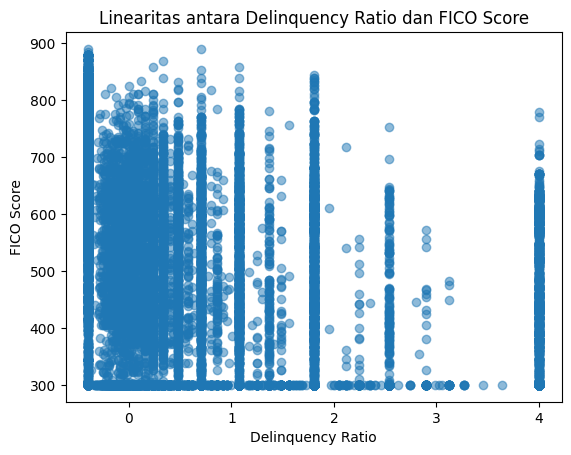

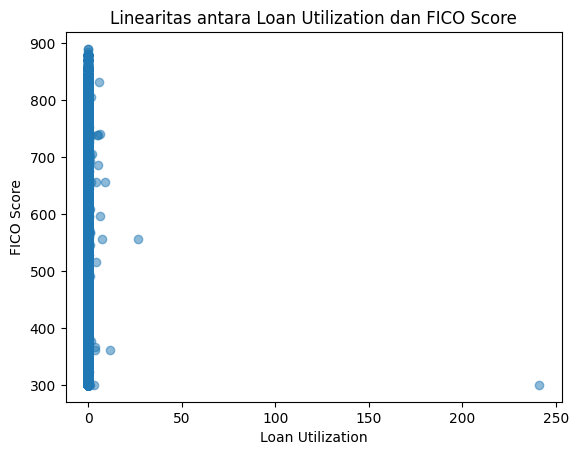

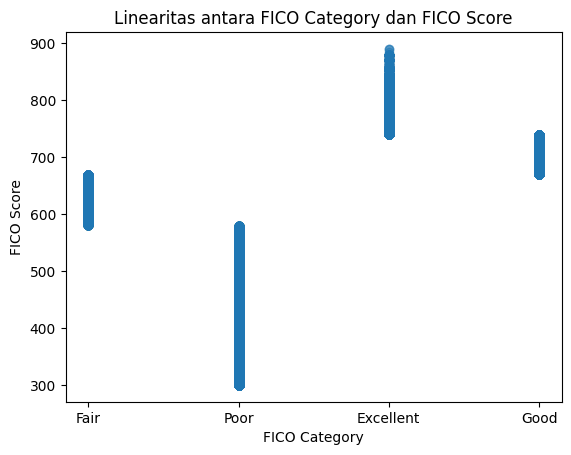

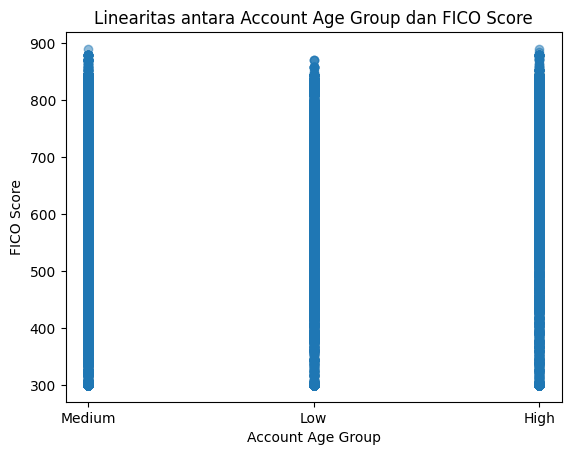

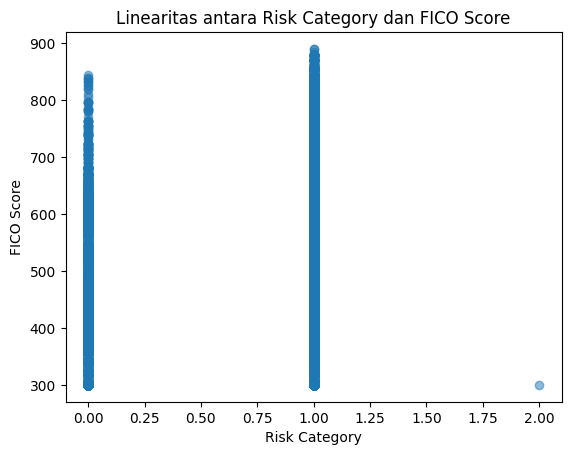

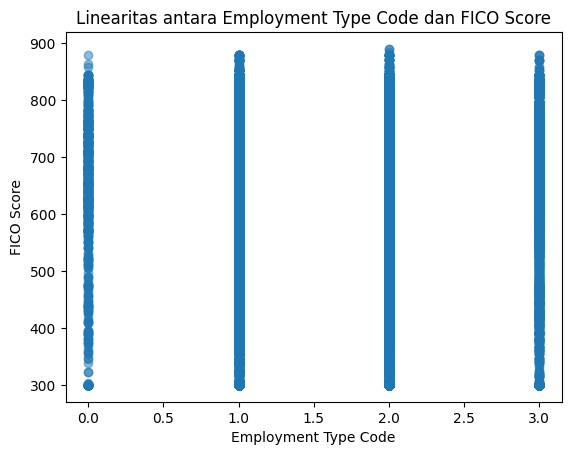

c:\Users\Fawwaz Widyadhana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Multikolinearitas (VIF):
                                    Feature          VIF
0                                  UniqueID     1.002801
1                             Loan To Value     1.025665
2                                 Branch ID     1.001906
3                                       Age     1.104787
4                          Employee_code_ID     0.000000
5                           Mobile Avl Flag     0.000000
6                              VoterID Flag     1.015178
7                        Number of Accounts     1.862845
8                 Number of Active Accounts     2.980162
9                Number of Overdue Accounts     2.109949
10                   Current Balance Amount     1.362766
11                        Sanctioned Amount  2804.155805
12                         Disbursed Amount  2812.041837
13                        Instalment Amount     1.059863
14  Number of Accounts Opened Last 6 Months     2.095702
15    Number of Delinquencies Last 6 Months     1.307193
16    

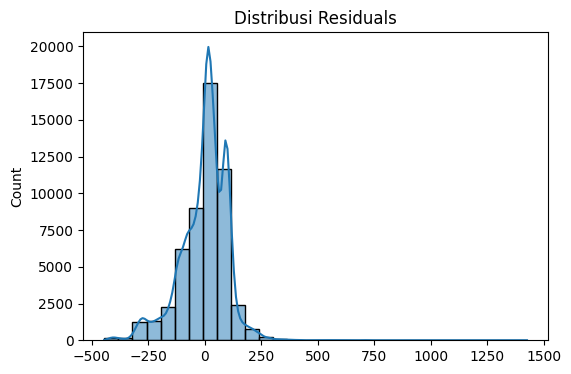

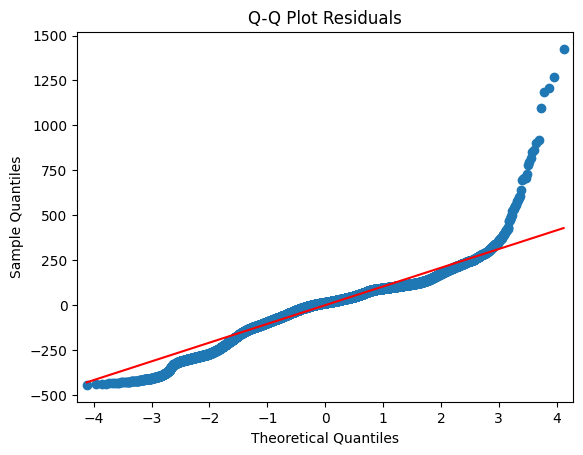

Shapiro-Wilk Test: p-value = 1.2229174615000272e-82
Residuals tidak berdistribusi normal


In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

# Misalkan df adalah data setelah pembersihan
df = df[df["FICO Score"] >= 300]
df.reset_index(drop=True, inplace=True)  # Reset index setelah penghapusan

# Pastikan "FICO Score" ada di dataset
target = "FICO Score"
features = [col for col in df.columns if col != target]

# ----------------- 1. Pengecekan Linearitas -----------------
plt.figure(figsize=(12, 6))
for feature in features:
    plt.scatter(df[feature], df[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'Linearitas antara {feature} dan {target}')
    plt.show()

# ----------------- 2. Pengecekan Multikolinearitas (VIF) -----------------
# Pilih hanya kolom numerik untuk analisis VIF
X_numeric = X.select_dtypes(include=[np.number])

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print("Multikolinearitas (VIF):")
print(vif_data)

# ----------------- 3. Pengecekan Homoskedastisitas (Uji Breusch-Pagan) -----------------
# Pastikan hanya menggunakan kolom numerik
X = df[features].select_dtypes(include=[np.number])

# Tambahkan konstanta untuk OLS
X = sm.add_constant(X)

# Pastikan tidak ada NaN
X = X.dropna()
y = y.loc[X.index]  # Samakan index y dengan X yang sudah dibersihkan

# Jalankan regresi
model = sm.OLS(y, X).fit()

# Uji Breusch-Pagan untuk Homoscedasticity
_, pval, _, _ = het_breuschpagan(model.resid, X)

# Cek hasil
if pval > 0.05:
    print("Homoscedasticity terpenuhi (p-value > 0.05)")
else:
    print("Heteroscedasticity terdeteksi (p-value <= 0.05)")

# ----------------- 4. Pengecekan Normalitas Error Terms -----------------
residuals = model.resid

# Plot Histogram Residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribusi Residuals")
plt.show()

# Q-Q Plot Residuals
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot Residuals")
plt.show()

# Uji Shapiro-Wilk
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue}")
if shapiro_test.pvalue > 0.05:
    print("Residuals berdistribusi normal")
else:
    print("Residuals tidak berdistribusi normal")


In [40]:
# One-Hot Encoding for categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)  

In [41]:
print(X_train.dtypes)  # Checking the data types of the columns

Loan To Value               float64
Branch ID                     int64
Age                         float64
Employee_code_ID              int64
Mobile Avl Flag               int64
                             ...   
FICO Category_Fair             bool
FICO Category_Good             bool
FICO Category_Poor             bool
Account Age Group_Medium       bool
Account Age Group_High         bool
Length: 132, dtype: object


In [42]:
# Converting categorical target to numerical codes
y_train = y_train.cat.codes

# Checking the updated dtype
print(y_train.dtypes)

int8


**Classification Model**

📌 Tujuan: Memprediksi kategori dari data berdasarkan fitur yang diberikan.

✅ Tips:

Gunakan Logistic Regression untuk data linear.

Gunakan Random Forest untuk data yang kompleks.

Gunakan XGBoost jika butuh model yang powerful dan cepat.

Gunakan Hyperparameter Tuning untuk optimasi model.

Logistic Regression: Model sederhana untuk memprediksi apakah nasabah termasuk dalam kategori risiko tertentu.

In [43]:
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [44]:
# Checking model training success
print("Model trained successfully!")

Model trained successfully!


In [45]:
# Checking the shape of both the features and the target variable
print(X_train.shape)
print(y_train.shape)

(47581, 132)
(47581,)


**Evaluation Metrics**

📌 Tujuan: Mengukur performa model untuk memastikan prediksi yang akurat.

✅ Tips:

Gunakan Accuracy untuk data yang seimbang.

Gunakan Precision & Recall jika ada ketidakseimbangan kelas.

Gunakan F1-Score untuk keseimbangan antara precision dan recall.

Gunakan ROC-AUC untuk evaluasi klasifikasi biner.

Evaluasi Model: Menggunakan Confusion Matrix dan Classification Report untuk melihat performa prediksi model.

In [46]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[   68   992]
 [   97 10739]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.06      0.11      1060
           1       0.92      0.99      0.95     10836

    accuracy                           0.91     11896
   macro avg       0.66      0.53      0.53     11896
weighted avg       0.87      0.91      0.88     11896



In [47]:
# Predicting probabilities instead of labels
y_probs = model.predict_proba(X_test)[:, 1]  

# Setting a custom threshold
threshold = 0.3  
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluating the new predictions
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

[[   21  1039]
 [   32 10804]]
              precision    recall  f1-score   support

           0       0.40      0.02      0.04      1060
           1       0.91      1.00      0.95     10836

    accuracy                           0.91     11896
   macro avg       0.65      0.51      0.50     11896
weighted avg       0.87      0.91      0.87     11896



Random Forest: Model yang lebih kompleks dan akurat dalam menentukan kategori risiko kredit.

In [48]:
model = RandomForestClassifier(class_weight={0: 2, 1: 1}, random_state=42)
model.fit(X_train, y_train)

# Menyimpan model menggunakan joblib
import joblib

# Menyimpan model yang sudah dilatih ke file
joblib.dump(model, 'logistic_regression_model.pkl')

# Memuat kembali model yang disimpan untuk uji coba
loaded_model = joblib.load('logistic_regression_model.pkl')

# Mengevaluasi model yang disimpan pada data uji
y_pred = loaded_model.predict(X_test)

# Menampilkan hasil evaluasi
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report for the Test Data:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix for the Test Data:")
print(confusion_matrix(y_test, y_pred))


# Evaluating the model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Classification Report for the Test Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1060
           1       1.00      1.00      1.00     10836

    accuracy                           1.00     11896
   macro avg       1.00      1.00      1.00     11896
weighted avg       1.00      1.00      1.00     11896

Confusion Matrix for the Test Data:
[[ 1059     1]
 [    6 10830]]
[[ 1059     1]
 [    6 10830]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1060
           1       1.00      1.00      1.00     10836

    accuracy                           1.00     11896
   macro avg       1.00      1.00      1.00     11896
weighted avg       1.00      1.00      1.00     11896



Melakukan Cross-Validation: Menguji model dengan berbagai pembagian data untuk memastikan keandalan hasil prediksi.

In [49]:
X_encoded = pd.get_dummies(X, drop_first=True)  

model = RandomForestClassifier(random_state=42)

scores = cross_val_score(model, X_encoded, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.4f}")

Cross-validated accuracy: 0.9991


Menghitung Error: Menggunakan metrik seperti Mean Absolute Error (MAE) dan Mean Squared Error (MSE) untuk melihat sejauh mana kesalahan prediksi model.

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# After making predictions, you can calculate these metrics:

# Calculating the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculating the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculating the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculating the R2 Score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")


Mean Absolute Error (MAE): 0.0005884330867518494
Mean Squared Error (MSE): 0.0005884330867518494
Root Mean Squared Error (RMSE): 0.024257639760534192
R2 Score: 0.992750231583053


Berikut adalah interpretasi metriknya:  

1. **Mean Absolute Error (MAE) = 0.00059**  
   → Rata-rata kesalahan prediksi hanya sekitar **0.00059** dari nilai sebenarnya. Ini menunjukkan model memiliki kesalahan yang sangat kecil.  

2. **Mean Squared Error (MSE) = 0.00059**  
   → MSE mengukur rata-rata kuadrat kesalahan. Semakin kecil nilai MSE, semakin baik modelnya. Karena nilainya sangat kecil, ini menunjukkan prediksi yang akurat.  

3. **Root Mean Squared Error (RMSE) = 0.0243**  
   → RMSE adalah akar dari MSE, yang lebih mudah diinterpretasikan dalam satuan yang sama dengan target variabel. Nilai **0.0243** menunjukkan bahwa rata-rata kesalahan prediksi sangat kecil.  

4. **R² Score = 0.9928 (99.28%)**  
   → R² atau **koefisien determinasi** mengukur seberapa baik model menjelaskan variabilitas data. Nilai **0.9928** berarti model menjelaskan **99.28%** variabilitas dalam data, yang sangat tinggi.  

**Kesimpulan:**  
Modelnya **sangat baik** dalam memprediksi risiko kredit. Dengan R² mendekati **1** dan error yang sangat kecil, model ini bisa dipercaya untuk memberikan keputusan berbasis data. Namun, tetap lakukan uji coba tambahan dengan **data baru** (out-of-sample testing) untuk memastikan tidak terjadi **overfitting**. 

***Testing Permodelan***

In [ ]:
# Import libraries
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved model
loaded_model = joblib.load('logistic_regression_model.pkl')

# Step 1: Load the original dataset (assuming it's in CSV format for this example)
# Gantilah path berikut sesuai dengan lokasi file dataset asli Anda
original_data = pd.read_csv('Data Scientist - Assignment.csv')

# Step 2: Preprocessing data
# Misalnya, jika dataset asli memiliki kolom yang perlu diproses, pisahkan fitur dan target variabelnya
# Gantilah 'target_column' dengan nama kolom target Anda dan 'feature_columns' dengan kolom fitur yang relevan
X_original = original_data[['Loan To Value', 'DisbursalDate', 'Current Balance Amount']]  # Sesuaikan dengan kolom fitur Anda
y_original = original_data['Age']  # Gantilah dengan nama kolom target Anda

# Step 3: Predict using the loaded model
y_pred_original = loaded_model.predict(X_original)

# Step 4: Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_original, y_pred_original))

print("Confusion Matrix:")
print(confusion_matrix(y_original, y_pred_original))

# Optionally, you can calculate the accuracy on the original dataset
accuracy_original = loaded_model.score(X_original, y_original)
print(f"Model Accuracy on Original Dataset: {accuracy_original * 100:.2f}%")
